In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn.gaussian_process as gp

In [27]:
#define the gaussian process model

def gaussian(df, l = 16):
    train_df = df[df.label!='OOD']
    train_y = train_df.label.values
    train_x = train_df.drop(columns = ['label']).values

    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    model.fit(train_x, train_y)
    params = model.kernel_.get_params()

    whole_y = df.label.replace('OOD', -1).values
    whole_x = df.drop(columns = ['label']).values
    y_pred, std = model.predict(whole_x, return_std=True)
    
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
#     plt.figure(figsize=[8,5])
    
    df_new = pd.DataFrame(dict(x=whole_x[:,0], y=whole_x[:,1], label=y_pred))
    sns.scatterplot(data=df_new, x="x", y="y", hue="label", ax = ax[0]);
    
    
    x = np.linspace(-l,l,1000).reshape(-1,1)
    y = np.linspace(-l,l,1000).reshape(-1,1)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((1000,1000))

    for i in range(1000):
    #     for j in range(1000):
        xy = np.concatenate((X[i].reshape(-1,1), Y[i].reshape(-1,1)), axis = 1)
        y_pred_new, std_new = model.predict(xy, return_std=True)
        Z[i] = std_new

    ax[1].pcolor(X, Y, Z)
    ax[1].scatter(df[df.label==0].x, df[df.label==0].y, color = 'blue')
    ax[1].scatter(df[df.label==1].x, df[df.label==1].y, color = 'green')
    ax[1].scatter(df[df.label==2].x, df[df.label==2].y, color = 'red')
    ax[1].scatter(df[df.label=='OOD'].x, df[df.label=='OOD'].y, color = 'yellow')
    plt.show()
    
    return model

### 1. Well-Seperated and Linearly-Seperable

In [3]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

#### a) ODD-ring

In [4]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

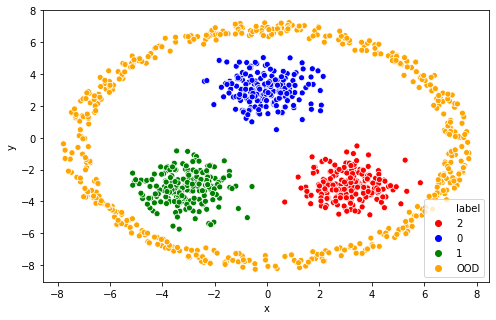

In [5]:
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a = df1a.append(df1a_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

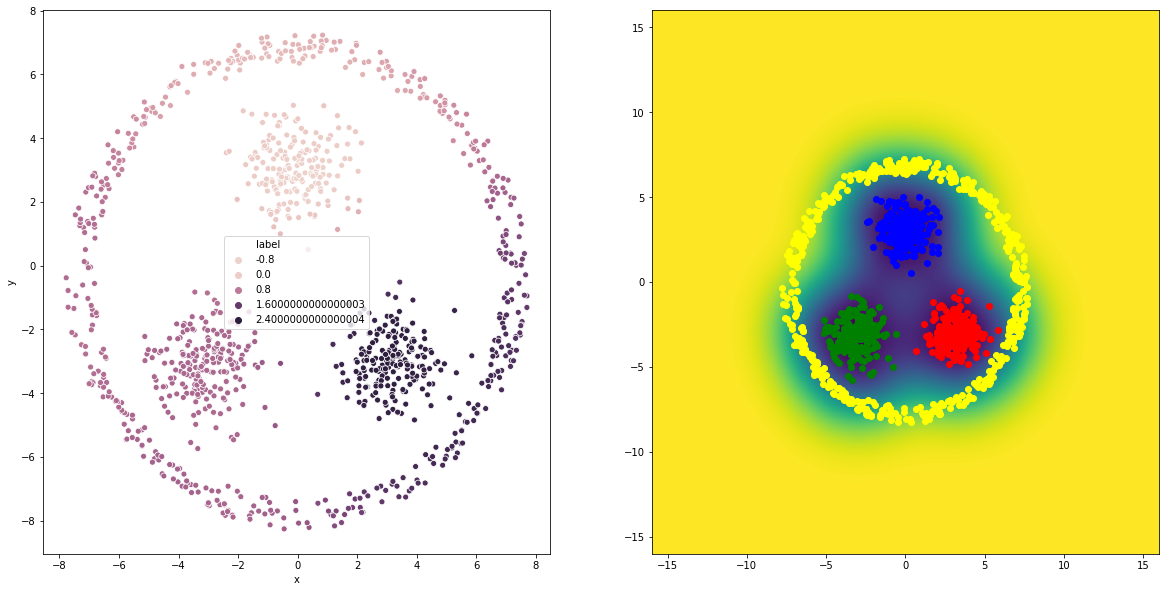

In [8]:
model1a = gaussian(df1a)

#### b) OOD-semicircle

In [9]:
# generate OOD
np.random.seed(0)
r = 6 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

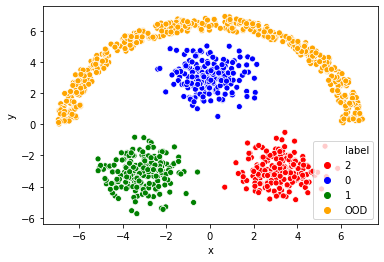

In [10]:
df1b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1b = df1b.append(df1b_ood, ignore_index=True)

sns.scatterplot(data=df1b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

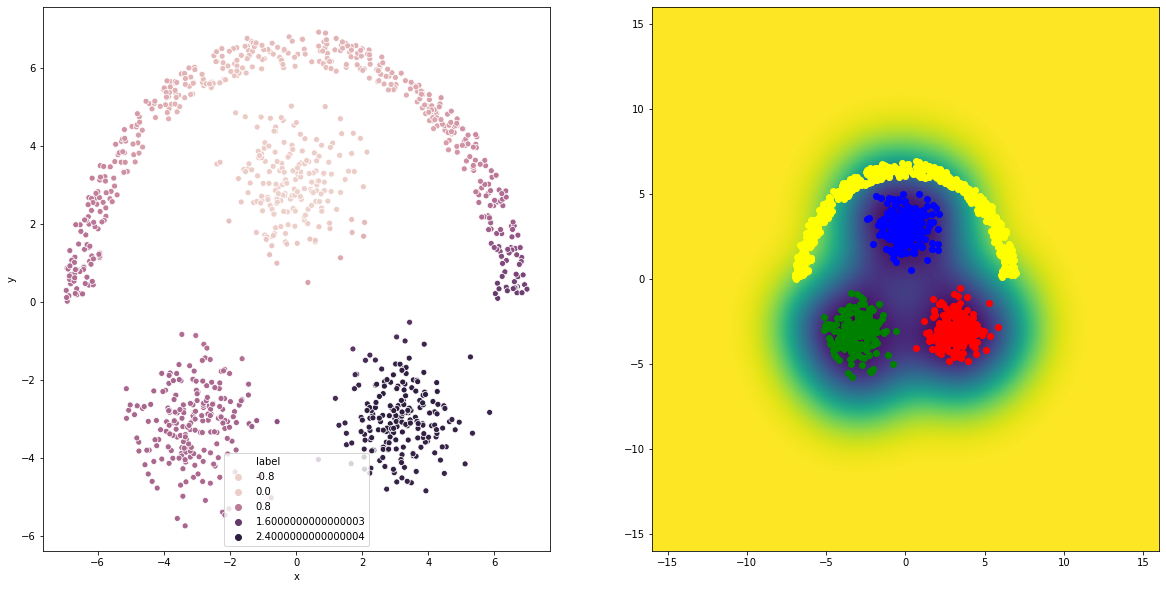

In [11]:
model1b = gaussian(df1b)

### 2. Well-Seperated and Linearly-Seperable, but clusters are far away from each other

In [12]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 6], [-6, -6], [6, -6]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

#### a) one ODD boundary

In [13]:
# generate OOD
np.random.seed(0)
r = 11.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-1+(r + random.random())*np.sin(angle))

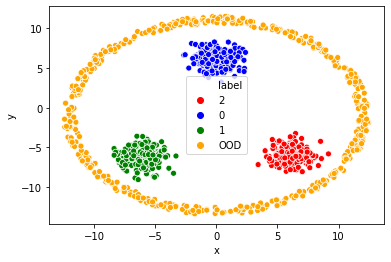

In [14]:
df2a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2a = df2a.append(df2a_ood, ignore_index=True)

sns.scatterplot(data=df2a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

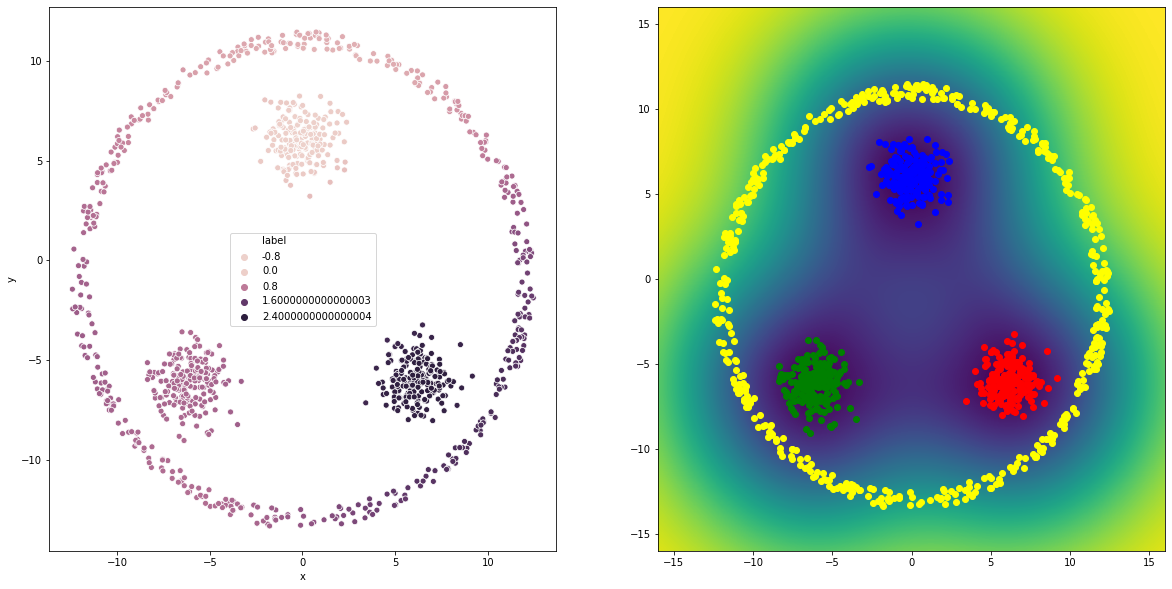

In [15]:
model2a = gaussian(df2a)

#### b) three ODD boundary

In [16]:
# generate OOD
np.random.seed(42)
r = 3.5 # radius
cx1, cx2, cx3 = 0, -6, 6
cy1, cy2, cy3 = 6, -6, -6
x1, x2 = [], []
for _ in range(500//3):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(cx1 + (r + random.random())*np.cos(angle))
    x1.append(cx2 + (r + random.random())*np.cos(angle))
    x1.append(cx3 + (r + random.random())*np.cos(angle))
    x2.append(cy1 + (r + random.random())*np.sin(angle))
    x2.append(cy2 + (r + random.random())*np.sin(angle))
    x2.append(cy3 + (r + random.random())*np.sin(angle))

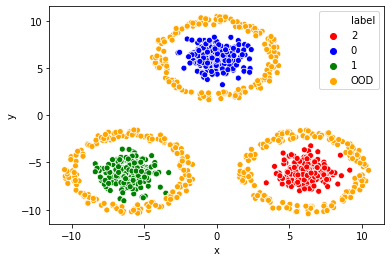

In [17]:
df2b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2b = df2b.append(df2b_ood, ignore_index=True)

sns.scatterplot(data=df2b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

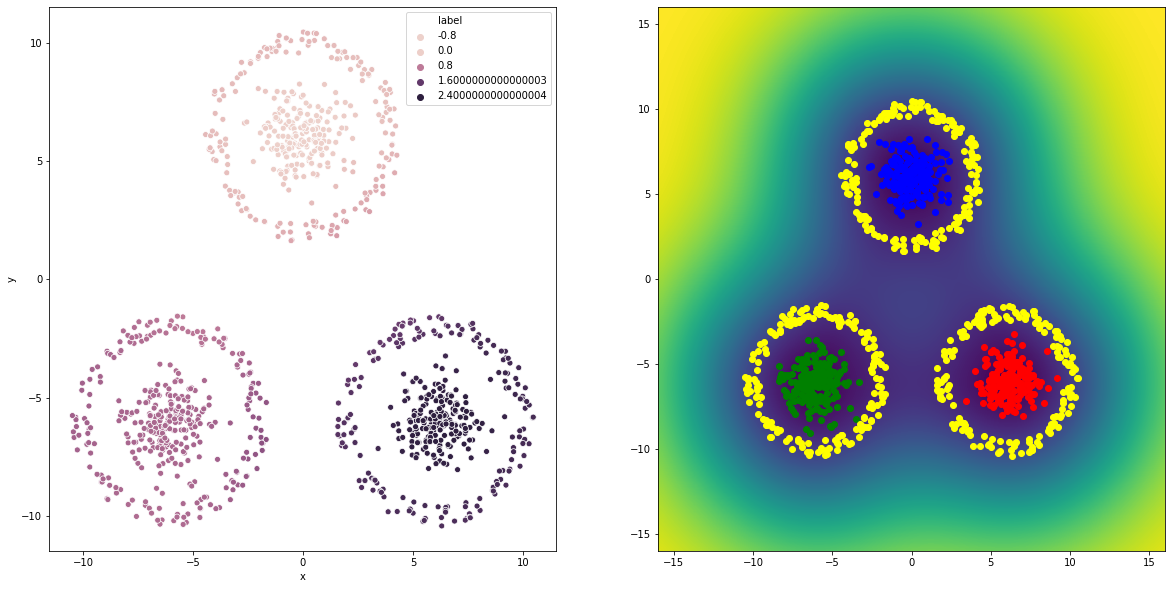

In [18]:
model2b = gaussian(df2b)

### 3. Not Well-Seperated

In [19]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 1], [-1, -1], [1, -1]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

In [20]:
# generate OOD
np.random.seed(42)
r = 4.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

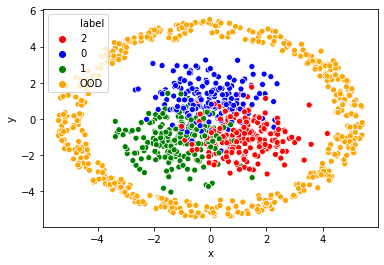

In [21]:
df3 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df3_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df3 = df3.append(df3_ood, ignore_index=True)

sns.scatterplot(data=df3, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

In [ ]:
model3 = gaussian(df3, l = 5)

### 4. Well-Seperated by non-linear boundary

In [23]:
X, y = datasets.make_moons(n_samples=600, shuffle=True, noise=0.1, random_state=0)

In [24]:
# generate OOD
np.random.seed(0)
r = 2 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(.5+(r + random.random())*np.cos(angle))
    x2.append(.3+(r + random.random())/1.5*np.sin(angle))

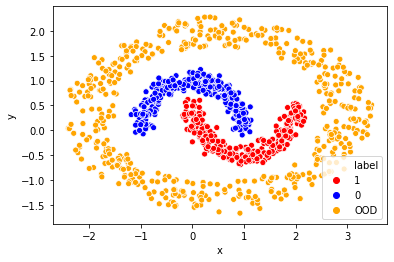

In [25]:
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a = df1a.append(df1a_ood, ignore_index=True)

sns.scatterplot(data=df1a, x="x", y="y", hue="label", palette=["red", "blue", "orange"]);

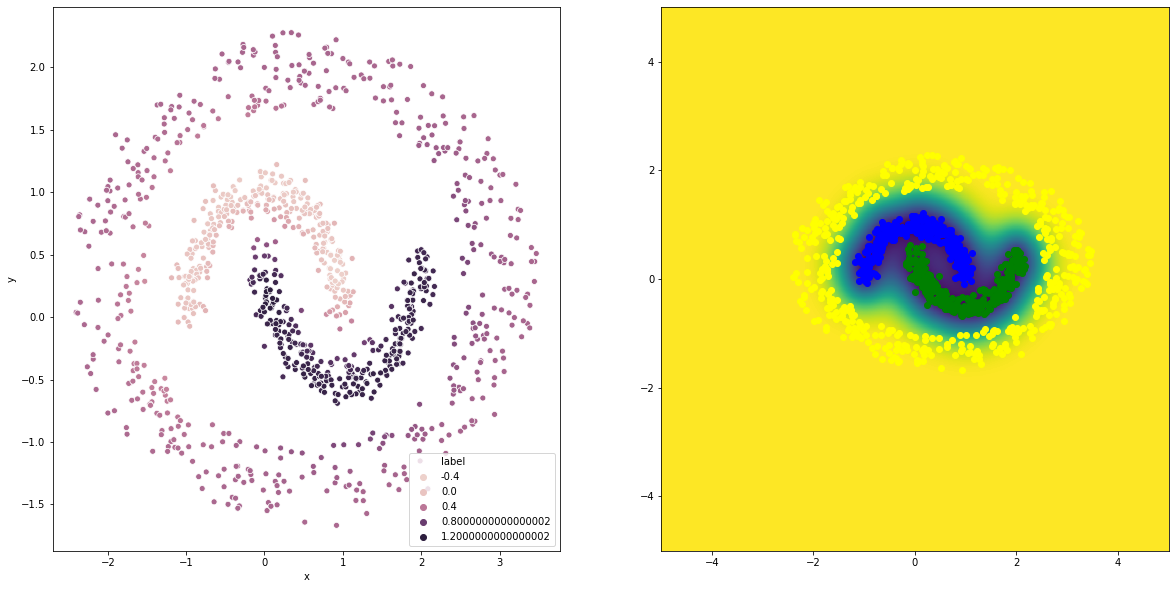

In [28]:
model4 = gaussian(df1a, l = 5)